# Génération de gaussienne par modèle de diffusion

## Yang Song
https://yang-song.net/blog/2021/score/

Given a dataset $\{x_1,...,x_n\}$ that follows $p(x)$, generate new point that samples this distribution.

Common way of doing so: maximize $\sum_{i=1}^N log p_\theta (x_i)$. But $p_\theta(x)$ need to be normalized, impossible for things like faces etc.

The idea is to use a **score function** instead of the classical maximal-likelihood. I.e. $\nabla_x log p (x)$. 

To train this model we would like to use the **Fisher Divergence** $E_{p(x)} || \nabla_x log p(x) - s_\theta (x)||_2^2$ but, and even to approximate it using a finite sum, we would need the value of $\nabla_x log p(x)$ on some point It can be done, check the ref.

### Langevin
Suppose that we have a score-bases model $s_\theta (x) \approx \nabla_x log p (x)$.

We can use a MCMC to sample from $p(x)$ by only knowing $\nabla_x log p(x)$:
$$
x_{i+1} \leftarrow x_i + \epsilon \nabla_x log p (x) + \sqrt{2 \epsilon} z_i
$$

Using $$ f(x) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x - \mu)2}{2\sigma2}\right) $$
So we need an esimation of $\nabla_x logp(x)$. 

### Denoising Diffusion Probabilistic Model
[[2006.11239v2.pdf]]

This paper allowed me to get a working generation of Gaussian point. Here are the key concepts.

We have $\mathcal{X} = \{x_1,\ldots,x_n\}$ that follows an unknown PDF $p_{\theta^*}$. The goal is to generate new points from this PDF. We will do it using a noising process and reverse process, according to:
$$
\begin{align}
q(x_t \mid x_{t-1}) &= \mathcal{N}(\sqrt{1 - \beta_t} x_{t-1}, \beta_t I)\\
q(x_{1:T} \mid x_0) &= \prod_{t=1}^T q(x_t \mid x_{t-1})
\end{align}
$$
![[Pasted image 20241110233216.png]]

We can rewrite the value of $x_T$ ($\alpha_t = 1 - \beta_t$ and $\bar{\alpha_t}$ is the product of the $\alpha_i$ for $i \leq t$):
$$
\begin{align}
x_t &= \sqrt{\alpha_t}x_{t-1} + \sqrt{1 - \alpha_t} \epsilon_{t-1} \\
&= \sqrt{\alpha_t \alpha_{t-1}} x_{t-2} + \sqrt{\alpha_t} \sqrt{1-\alpha_{t-1}} \epsilon_{t-2} + \sqrt{1 - \alpha_t} \epsilon_{t-1} \\
&= \sqrt{\alpha_t \alpha_{t-1}} x_{t-2} + \sqrt{\alpha_t(1 - \alpha_{t-1})} \epsilon_{t-2} + \sqrt{1 - \alpha_t} \epsilon_{t-1}
\end{align}
$$
Let $G_1 \sim \mathcal{N}(0,\sigma_1^2 I)$, $G_2 \sim \mathcal{N}(0,\sigma_2^2 I)$ , the sum of them gives $g_2 \sim \mathcal{N}(0,(\sigma_1^2 + \sigma_2^2) I)$.  We apply this to the two terms on the right:
$$
\begin{align}
x_t &= \sqrt{\alpha_t \alpha_{t-1}} x_{t-2} + \sqrt{\alpha_t(1 - \alpha_{t-1}) + 1 - \alpha_t} \bar{\epsilon_t} \\ &= \sqrt{\alpha_t \alpha_{t-1}} x_{t-2} + \sqrt{1 - \alpha_t \alpha_{t-1}} \bar{\epsilon_t}
\end{align}
$$
According to Lilian Weng blog (maybe also from the article), taking $\beta_1 < \ldots < \beta_T$ is the best method.

We can then ==directly add noise==$x_t = \sqrt{\bar{\alpha_t}}x_0 + \sqrt{1 - \bar{\alpha_t}} \epsilon$. The next step is to compute the denoising.

Suppose that we have $x_0$ (i.e. we know from which element of $\mathcal{X}$ we sampled to get to $x_T$). It's easy tractable to compute $q(x_{t-1} \mid x_t,x_0)$:
$$
\begin{align}
q(x_{t-1} \mid x_t, x_0) &= q(x_{t} \mid x_{t-1},x_0) \frac{q(x_{t-1} \mid x_0)}{q(x_t \mid x_0)} \\
&= \ldots
\end{align}
$$
The whole expression isn't really useful (it is in the notebook), but what is cool is the form $q(x_{t-1} \mid x_t, x_0) = \mathcal{N}(x_{t-1}; \mu(x_t,x_0); \gamma_t I)$ where the only factor that uses $x_0$ is $\mu$.
Or, using the expression of $x_t$, we know that $x_0 = \frac{1}{\sqrt{\bar{\alpha}_t}} (x_t - \sqrt{1 - \bar{\alpha_t}} \epsilon)$. Hence, we can have an expression $\mu(x_t,t)$.

The idea of the paper is to ==train a neural network to approximate the function $q(x_{t-1} \mid x_t)$== :

$p_\theta (x_{t-1} \mid x_t) = \mathcal{N}(x_{t-1}; \mu_{\theta} (x_t,t), \beta_t I)$.
**Question**: Marc Lelarge replaced $\gamma_t$ by just $\beta_t$, why ?

**Hypothesis**: It is too precise with $\gamma_t$ and it is not creative enough. But if we are far from the repartition we want we may try this.


Now, to train a network we need a Loss function. Here we choose the MSE because:

Explication à venir, la je suis out.


In [36]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import normal
import matplotlib.pyplot as plt
import numpy as np
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

(1000, 2)


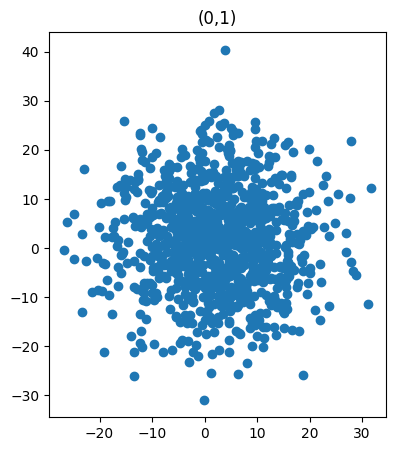

In [37]:
def show_points(X):
    print(X.shape)
    nb_points,dim = X.shape
    plt.figure(figsize=(dim*(dim-1) * 10,5))
    nb_plot=0
    for d1 in range(dim):
        for d2 in range(d1+1,dim):
            xs,ys = [],[]
            nb_plot+=1
            for i in range(nb_points):
                xs.append(X[i][d1])
                ys.append(X[i][d2])
            plt.subplot(1,dim**2,nb_plot)
            plt.title(f"({d1},{d2})")
            plt.scatter(xs,ys)
    plt.show()
    return
n_steps = 1000
dim = 2
points = np.array([torch.normal(mean=2*torch.ones((dim,)), std=10*torch.ones((dim,))) for _ in range(1000)])
show_points(points)

In [146]:
class Net(nn.Module):
    def __init__(self,inpSize,outpSize):
        """
        Ce network sert à sampler epsilon_theta (x_t,t)
        """
        super(Net,self).__init__()
        self.inpsize = inpSize
        self.linear1 = torch.nn.Linear(inpSize,256).to(device)
        self.act = torch.nn.SiLU().to(device)
        self.linear2 = torch.nn.Linear(256,outpSize).to(device)

    def forward(self,x,t):
        x = x.to(device)
        z = torch.cat([x, t.unsqueeze(1)], dim=1).to(device)
        out = self.linear2(self.act(self.linear1(z))).to(device)
        return out

linearNet = Net(dim+1,dim)

In [147]:
class Diff(nn.Module):
    def __init__(self,network, num_timesteps,beta_start = 0.0001, beta_end = 0.02, device = "cpu"):
        super(Diff,self).__init__()
        self.num_timesteps = num_timesteps
        self.betas = torch.linspace(beta_start,beta_end,num_timesteps,dtype=torch.float32)
        self.betas = self.betas.to(device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas,axis=0)
        self.network = network
        self.device = device
        self.sqrt_alphas_cumprod = self.alphas_cumprod**0.5
        self.sqrt_one_minus_alphas_cumprod = (1 - self.alphas_cumprod) ** 0.5
        self.betas = torch.linspace(beta_start,beta_end,num_timesteps,dtype=torch.float32).to(device)
    def add_noise(self, x_start, x_noise, timesteps):
        s1 = self.sqrt_alphas_cumprod[timesteps].reshape(-1,1).to(device) # bs
        s2 = self.sqrt_one_minus_alphas_cumprod[timesteps].reshape(-1,1).to(device) # bs
        return x_start * s1+  x_noise * s2
    def reverse(self,x,t):
        return self.network(x,t)
    def step(self, model_output, timestep, sample):
        t = timestep
        coef_epsilon = ((1-self.alphas)/self.sqrt_one_minus_alphas_cumprod).to(device)
        coef_eps_t = coef_epsilon[t].reshape(-1,1).to(device)
        coef_first = 1/self.alphas ** 0.5
        coef_first_t = coef_first[t].reshape(-1,1).to(device)
        #coef_first_t = (1/((self.alphas[t])**0.5)).reshape(-1,1)
        pred_prev_sample = (coef_first_t*(sample-coef_eps_t*model_output)).to(device)
        variance = 0
        if t > 0:
            noise = torch.randn_like(model_output).to(self.device)
            variance = ((self.betas[t] ** 0.5) * noise).to(device)

        pred_prev_sample = pred_prev_sample + variance
        return pred_prev_sample.to(device)

In [165]:
def training_loop(model,dataloader,optim,num_ep,num_timesteps,device=device):
    global_step = 0
    losses = []
    for epoch in range(num_ep):
        if epoch!= 0: print(f"New epoch ({epoch}) last losses: {losses[-1]}" )
        model.train()
        l = 0
        for step, batch in enumerate(dataloader):
            batch = batch.to(device)
            noise = torch.randn(batch.shape).to(device)
            timestep = torch.randint(num_timesteps,(batch.shape[0],)).long().to(device)
            noisy = model.add_noise(batch, noise, timestep)
            noise_pred = model.reverse(noisy, timestep)
            loss = F.mse_loss(noise_pred, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            logs = {"loss": loss.detach().item(), "step": global_step}
            l+=loss.detach().item()
            global_step += 1
        losses.append(l/len(dataloader))

In [149]:
from torch.utils.data import Dataset, DataLoader

In [150]:
class MultivariateNormalDataset(Dataset):
    def __init__(self, mean,std, num_samples):
        self.data = np.array([torch.normal(mean=mean, std=std) for _ in range(num_samples)])
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx]

In [161]:
num_samples = 10000  # Number of samples
batch_size = 32     # Batch size
mean = 3*torch.ones((dim,))
std = 0*torch.ones((dim,))
dataset = MultivariateNormalDataset(mean,std, num_samples)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [162]:

lr = 1e-3
num_epochs = 100
num_timesteps = 200
network = Net(dim+1,dim)
network = network.to(device)
model = Diff(network,num_timesteps,device = device)
optimizer = torch.optim.Adam(network.parameters(), lr=lr)
training_loop(model,dataloader,optimizer,num_epochs,num_timesteps)

New epoch (1) last losses: 1.2392204978976387
New epoch (2) last losses: 0.5376648504894
New epoch (3) last losses: 0.31248776057657723
New epoch (4) last losses: 0.21178829516418063
New epoch (5) last losses: 0.1692353759091883
New epoch (6) last losses: 0.14337313700967227
New epoch (7) last losses: 0.13710581949843575
New epoch (8) last losses: 0.11085181163487057
New epoch (9) last losses: 0.17725987733005524
New epoch (10) last losses: 0.11234512631766522
New epoch (11) last losses: 0.14907832951627123
New epoch (12) last losses: 0.08756378250190625
New epoch (13) last losses: 0.11117129039745362
New epoch (14) last losses: 0.10487145535981122
New epoch (15) last losses: 0.07461818555197396
New epoch (16) last losses: 0.11608638785133799
New epoch (17) last losses: 0.09021452156017526
New epoch (18) last losses: 0.12935256623267272
New epoch (19) last losses: 0.08063654768497894
New epoch (20) last losses: 0.07434404032533995
New epoch (21) last losses: 0.06316911645186024
New epo

In [163]:
def genere_un_point():
    sample = torch.randn(dim).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        timesteps = list(range(model.num_timesteps))[::-1]
        for i,t in enumerate(timesteps):
            time_tensor = (torch.ones(1,) * t).long().to(device)
            residual = model.reverse(sample,time_tensor)
            sample = model.step(residual,time_tensor,sample)
    return sample

(20, 2)


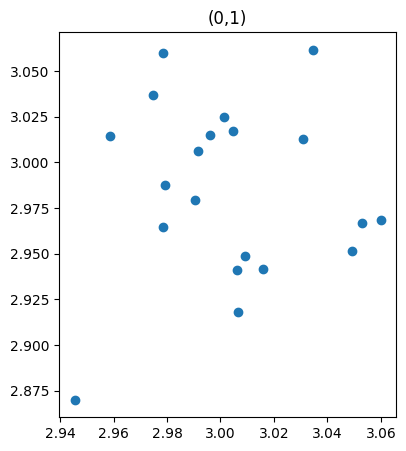

(40, 2)


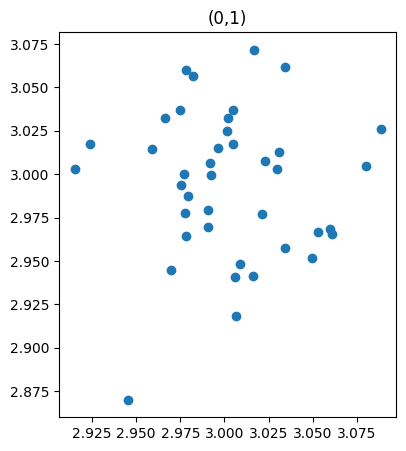

(60, 2)


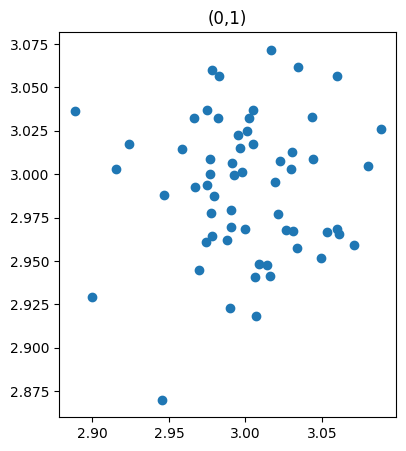

(80, 2)


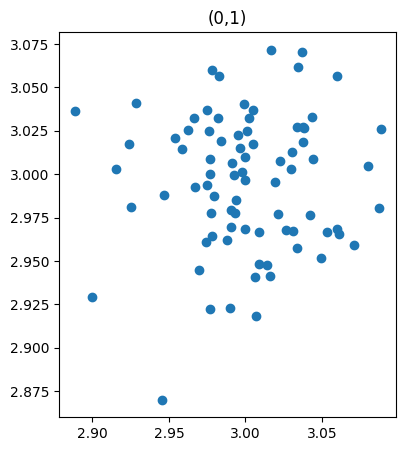

(100, 2)


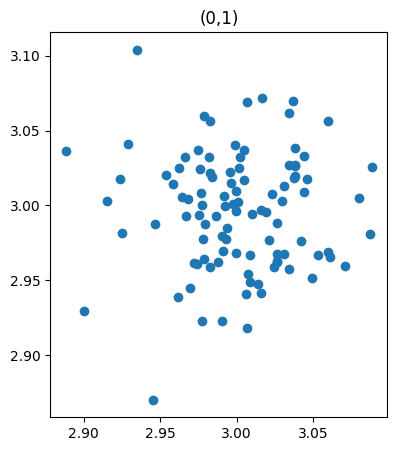

(120, 2)


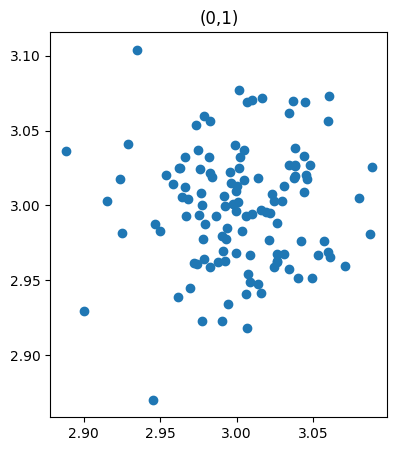

(140, 2)


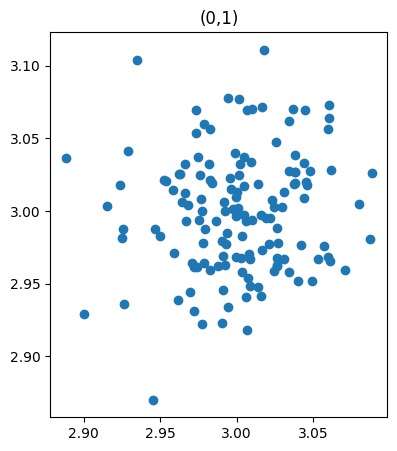

(160, 2)


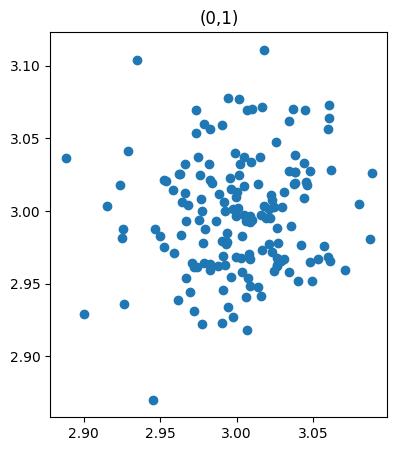

(180, 2)


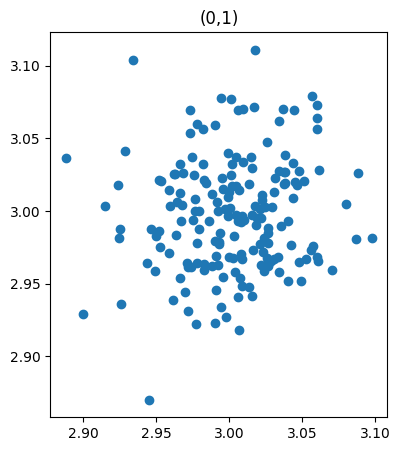

(200, 2)


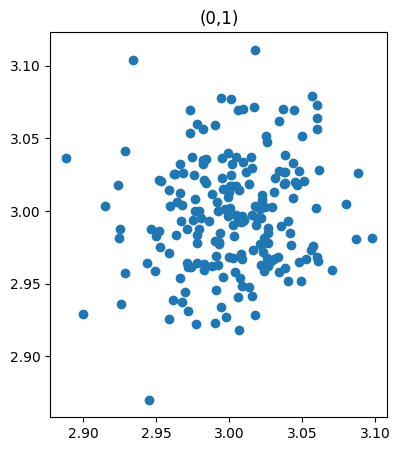

(220, 2)


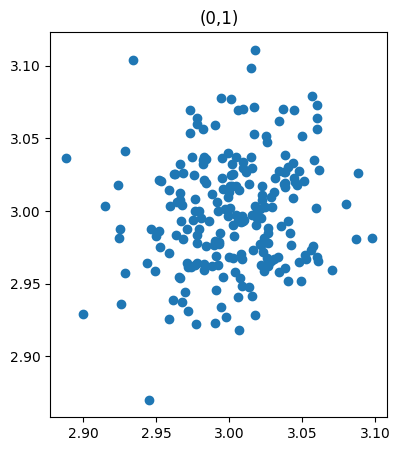

(240, 2)


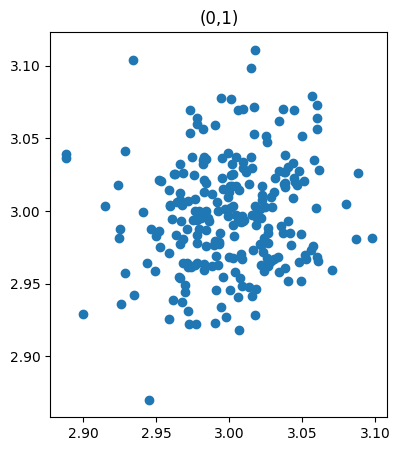

(260, 2)


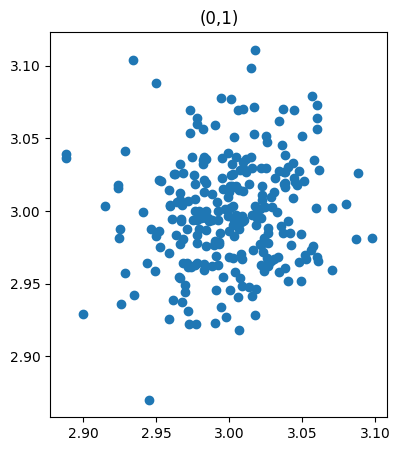

(280, 2)


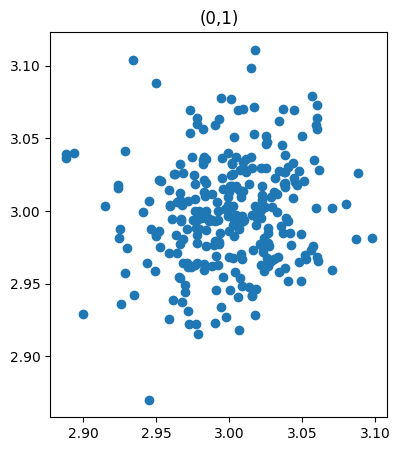

(300, 2)


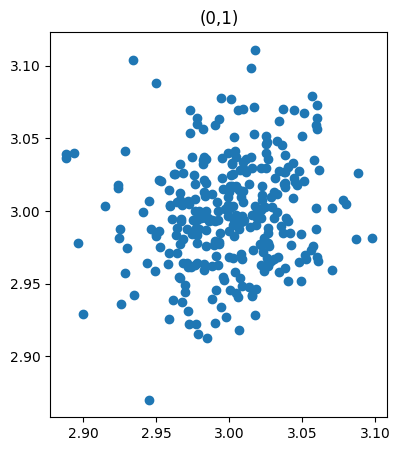

(320, 2)


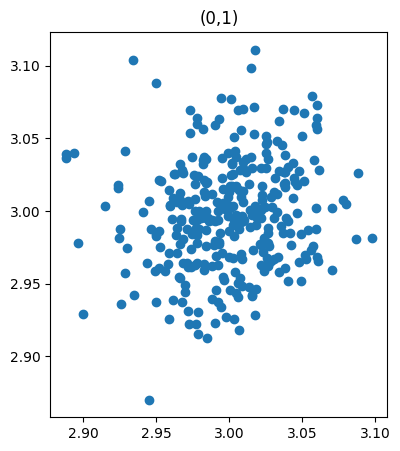

(340, 2)


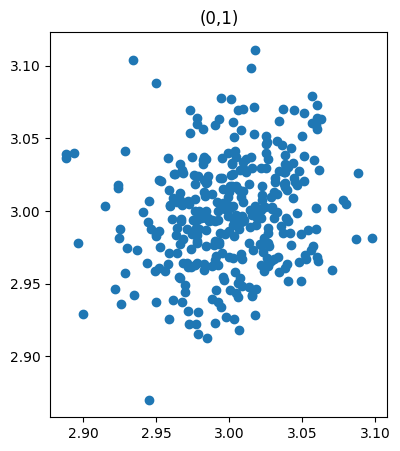

(360, 2)


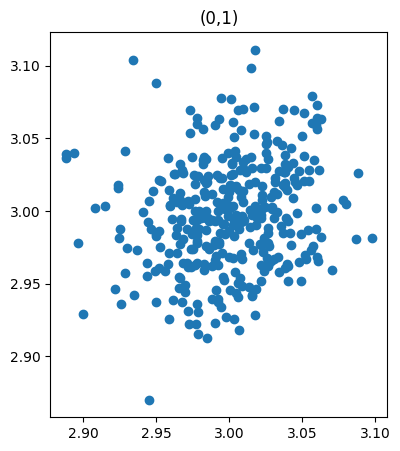

(380, 2)


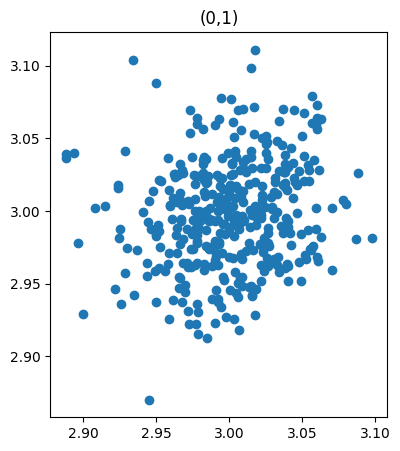

(400, 2)


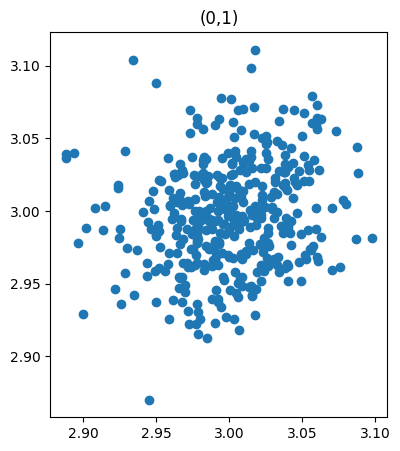

(420, 2)


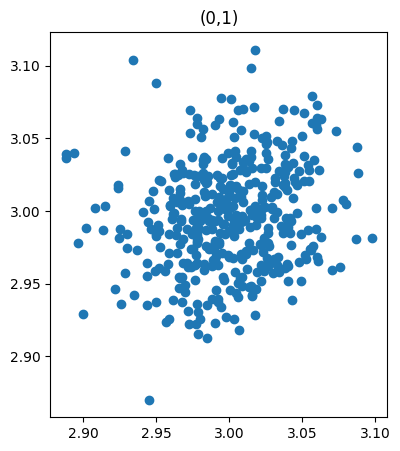

(440, 2)


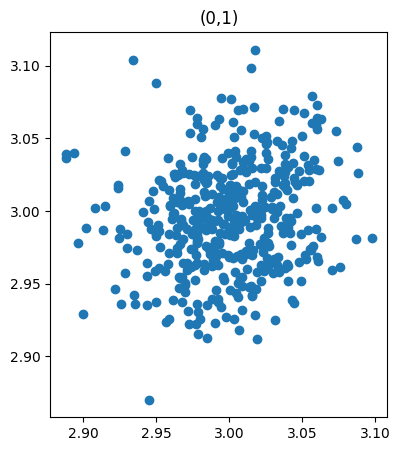

(460, 2)


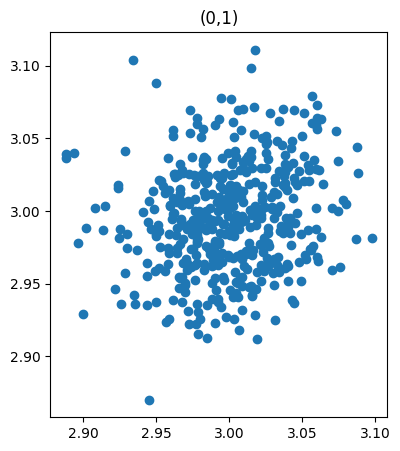

(480, 2)


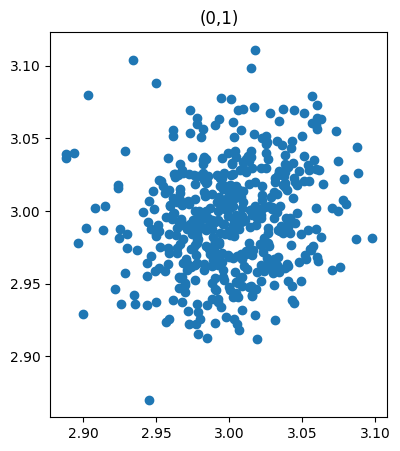

KeyboardInterrupt: 

In [164]:
X = []
while True:
    X.append(genere_un_point()[0])
    if len(X) % 20 == 0 and len(X)>0:
        Y = [x.cpu() for x in X]
        show_points(np.array(Y))